In [ ]:
!pip install tweepy transformers datasets nltk gensim matplotlib seaborn wordcloud scikit-learn


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Uninstall pandas and numpy
!pip uninstall -y pandas numpy

# Reinstall pandas and numpy. This will ensure they are installed with compatible versions.
# We also reinstall the other packages to be safe, though the primary issue is likely with pandas/numpy.
!pip install tweepy transformers datasets nltk gensim matplotlib seaborn wordcloud scikit-learn pandas numpy

Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
thinc 8.3.6 re

In [ ]:
import pandas as pd
import numpy as np

print("Pandas Version:", pd.__version__)
print("NumPy Version:", np.__version__)



Pandas Version: 2.2.2
NumPy Version: 1.26.4


In [ ]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
from transformers import pipeline
import nltk
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim import corpora

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

print("All libraries installed successfully!")

All libraries installed successfully!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def create_election_dataset():
    """Create a sample election dataset"""
    np.random.seed(42)

    # Sample tweet templates
    positive_tweets = [
        "Great policy speech today! Really inspiring vision for the future.",
        "Love the new healthcare plan - this will help so many families!",
        "Excellent debate performance. Clear, honest answers.",
        "Finally a candidate who listens to working people!",
        "Strong leadership when we need it most.",
    ]

    negative_tweets = [
        "Terrible policy decision. This will hurt the economy.",
        "Another broken promise from politicians.",
        "Weak debate performance. No real solutions offered.",
        "This candidate is out of touch with regular people.",
        "Same old politics, nothing will change.",
    ]

    neutral_tweets = [
        "Candidate will speak at town hall meeting tomorrow.",
        "New poll shows tight race in key swing states.",
        "Campaign rally scheduled for this weekend.",
        "Voter registration deadline is next month.",
        "Election day is approaching quickly.",
    ]

    parties = ['Republican', 'Democrat', 'Independent']
    states = ['California', 'Texas', 'New York', 'Florida', 'Pennsylvania']

    data = []

    # Create 2000 sample tweets
    for i in range(2000):
        # Randomly choose tweet type and content
        tweet_type = np.random.choice(['positive', 'negative', 'neutral'], p=[0.4, 0.3, 0.3])

        if tweet_type == 'positive':
            text = np.random.choice(positive_tweets)
        elif tweet_type == 'negative':
            text = np.random.choice(negative_tweets)
        else:
            text = np.random.choice(neutral_tweets)

        # Add party and hashtag
        party = np.random.choice(parties)
        text += f" #{party}2024 #Election2024"

        # Create timestamp (last 30 days)
        days_ago = np.random.randint(0, 30)
        timestamp = datetime.now() - timedelta(days=days_ago)

        data.append({
            'tweet_id': f"tweet_{i}",
            'text': text,
            'created_at': timestamp,
            'state': np.random.choice(states),
            'party_mentioned': party,
            'retweets': np.random.randint(0, 100),
            'likes': np.random.randint(0, 500)
        })

    return pd.DataFrame(data)

# Create our dataset
df = create_election_dataset()
print(f"Created dataset with {len(df)} tweets")
print(df.head())

Created dataset with 2000 tweets
  tweet_id                                               text  \
0  tweet_0  Strong leadership when we need it most. #Indep...   
1  tweet_1  Weak debate performance. No real solutions off...   
2  tweet_2  Election day is approaching quickly. #Democrat...   
3  tweet_3  Finally a candidate who listens to working peo...   
4  tweet_4  Great policy speech today! Really inspiring vi...   

                  created_at         state party_mentioned  retweets  likes  
0 2025-05-16 17:25:07.668202  Pennsylvania     Independent        20    102  
1 2025-05-03 17:25:07.668655  Pennsylvania     Independent        99    359  
2 2025-05-03 17:25:07.668893       Florida        Democrat        29    293  
3 2025-05-26 17:25:07.669075       Florida      Republican        57     21  
4 2025-04-30 17:25:07.669239      New York      Republican        41    475  


In [ ]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Add this line to download the required resource
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

print("All libraries installed successfully!")

def clean_text(text):
    """Clean tweet text for analysis"""
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove special characters but keep spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra spaces
    text = ' '.join(text.split())

    return text

def remove_stopwords(text):
    """Remove common English stopwords"""
    stop_words = set(stopwords.words('english'))
    # Add some political stopwords
    stop_words.update(['election', 'candidate', 'vote', 'campaign'])

    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]

    return ' '.join(filtered_words)

# Apply preprocessing
df['text_clean'] = df['text'].apply(clean_text)
df['text_processed'] = df['text_clean'].apply(remove_stopwords)

print("Text preprocessing completed!")
print("Original:", df['text'].iloc[0])
print("Cleaned:", df['text_clean'].iloc[0])
print("Processed:", df['text_processed'].iloc[0])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


All libraries installed successfully!
Text preprocessing completed!
Original: Strong leadership when we need it most. #Independent2024 #Election2024
Cleaned: strong leadership when we need it most independent election
Processed: strong leadership need independent


In [ ]:
print("Loading BERT sentiment model...")
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    return_all_scores=True
)

def analyze_sentiment_batch(texts, batch_size=50):
    """Analyze sentiment for multiple texts"""
    results = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch_results = []

        for text in batch:
            if not text or len(text.strip()) == 0:
                batch_results.append({'label': 'NEUTRAL', 'score': 0.5})
                continue

            try:
                # Get sentiment scores
                scores = sentiment_analyzer(text[:512])  # BERT has 512 token limit

                # Find the highest scoring sentiment
                best_result = max(scores[0], key=lambda x: x['score'])
                batch_results.append(best_result)

            except:
                batch_results.append({'label': 'NEUTRAL', 'score': 0.5})

        results.extend(batch_results)

        if i % 200 == 0:
            print(f"Processed {i}/{len(texts)} tweets")

    return results

# Analyze sentiment
print("Analyzing sentiment with BERT...")
sentiment_results = analyze_sentiment_batch(df['text_clean'].tolist())

# Add results to dataframe
df['sentiment'] = [result['label'] for result in sentiment_results]
df['sentiment_score'] = [result['score'] for result in sentiment_results]

# Clean up sentiment labels
df['sentiment'] = df['sentiment'].str.replace('LABEL_0', 'NEGATIVE')
df['sentiment'] = df['sentiment'].str.replace('LABEL_1', 'NEUTRAL')
df['sentiment'] = df['sentiment'].str.replace('LABEL_2', 'POSITIVE')

print("Sentiment analysis completed!")
print(df['sentiment'].value_counts())

Loading BERT sentiment model...


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


Analyzing sentiment with BERT...
Processed 0/2000 tweets
Processed 200/2000 tweets
Processed 400/2000 tweets
Processed 600/2000 tweets
Processed 800/2000 tweets
Processed 1000/2000 tweets
Processed 1200/2000 tweets
Processed 1400/2000 tweets
Processed 1600/2000 tweets
Processed 1800/2000 tweets
Sentiment analysis completed!
sentiment
positive    804
neutral     609
negative    587
Name: count, dtype: int64


In [ ]:
def prepare_text_for_lda(texts):
    """Prepare text data for LDA topic modeling"""
    # Tokenize texts
    tokenized_texts = []
    for text in texts:
        if text and len(text.strip()) > 0:
            tokens = text.split()
            # Keep tokens with length > 2
            tokens = [token for token in tokens if len(token) > 2]
            if tokens:  # Only add non-empty token lists
                tokenized_texts.append(tokens)

    return tokenized_texts

def train_lda_model(tokenized_texts, num_topics=5):
    """Train LDA topic model"""
    # Create dictionary and corpus
    dictionary = corpora.Dictionary(tokenized_texts)

    # Filter extreme words
    dictionary.filter_extremes(no_below=2, no_above=0.8)

    # Create corpus
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

    # Train LDA model
    lda_model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=10,
        alpha='auto'
    )

    return lda_model, dictionary, corpus

# Prepare data for topic modeling
print("Preparing data for topic modeling...")
tokenized_texts = prepare_text_for_lda(df['text_processed'])

# Train LDA model
print("Training topic model...")
lda_model, dictionary, corpus = train_lda_model(tokenized_texts, num_topics=5)

# Get topics
print("\nDiscovered Topics:")
for idx, topic in lda_model.print_topics():
    print(f"Topic {idx}: {topic}")

# Assign dominant topic to each tweet
def get_dominant_topic(text):
    """Get the dominant topic for a text"""
    if not text or len(text.strip()) == 0:
        return -1, 0.0

    tokens = text.split()
    tokens = [token for token in tokens if len(token) > 2]

    if not tokens:
        return -1, 0.0

    bow = dictionary.doc2bow(tokens)
    topic_probs = lda_model.get_document_topics(bow)

    if not topic_probs:
        return -1, 0.0

    # Get topic with highest probability
    dominant_topic = max(topic_probs, key=lambda x: x[1])
    return dominant_topic[0], dominant_topic[1]

# Apply topic modeling to all tweets
topic_results = df['text_processed'].apply(get_dominant_topic)
df['dominant_topic'] = [result[0] for result in topic_results]
df['topic_probability'] = [result[1] for result in topic_results]

print("Topic modeling completed!")
print(df['dominant_topic'].value_counts())

Preparing data for topic modeling...
Training topic model...

Discovered Topics:
Topic 0: 0.067*"economy" + 0.067*"hurt" + 0.067*"terrible" + 0.067*"decision" + 0.067*"policy" + 0.065*"new" + 0.065*"tight" + 0.065*"race" + 0.065*"key" + 0.065*"shows"
Topic 1: 0.059*"democrat" + 0.055*"republican" + 0.053*"independent" + 0.052*"new" + 0.052*"families" + 0.052*"many" + 0.052*"plan" + 0.052*"love" + 0.052*"help" + 0.052*"healthcare"
Topic 2: 0.083*"approaching" + 0.083*"quickly" + 0.083*"day" + 0.075*"democrat" + 0.073*"independent" + 0.068*"republican" + 0.067*"people" + 0.067*"regular" + 0.067*"touch" + 0.065*"registration"
Topic 3: 0.052*"republican" + 0.051*"performance" + 0.051*"debate" + 0.051*"excellent" + 0.051*"honest" + 0.051*"clear" + 0.051*"answers" + 0.048*"vision" + 0.048*"future" + 0.048*"inspiring"
Topic 4: 0.077*"republican" + 0.076*"people" + 0.076*"finally" + 0.076*"working" + 0.076*"listens" + 0.067*"leadership" + 0.067*"strong" + 0.067*"need" + 0.058*"democrat" + 0.05

In [ ]:
def analyze_sentiment_over_time(df):
    """Analyze how sentiment changes over time"""
    # Create date column
    df['date'] = pd.to_datetime(df['created_at']).dt.date

    # Calculate daily sentiment percentages
    daily_sentiment = df.groupby(['date', 'sentiment']).size().unstack(fill_value=0)
    daily_sentiment_pct = daily_sentiment.div(daily_sentiment.sum(axis=1), axis=0) * 100

    return daily_sentiment_pct

def analyze_party_sentiment_trends(df):
    """Analyze sentiment trends by political party"""
    party_trends = {}

    for party in df['party_mentioned'].unique():
        party_data = df[df['party_mentioned'] == party]
        party_daily = party_data.groupby(['date', 'sentiment']).size().unstack(fill_value=0)
        party_daily_pct = party_daily.div(party_daily.sum(axis=1), axis=0) * 100
        party_trends[party] = party_daily_pct

    return party_trends

# Perform time-based analysis
print("Analyzing sentiment trends over time...")
daily_sentiment_trends = analyze_sentiment_over_time(df)
party_sentiment_trends = analyze_party_sentiment_trends(df)

print("Time-based analysis completed!")

Analyzing sentiment trends over time...
Time-based analysis completed!


In [ ]:
def analyze_regional_sentiment(df):
    """Analyze sentiment differences across states"""
    # Sentiment by state
    regional_sentiment = df.groupby(['state', 'sentiment']).size().unstack(fill_value=0)
    regional_sentiment_pct = regional_sentiment.div(regional_sentiment.sum(axis=1), axis=0) * 100

    # Party preferences by state
    regional_party = df.groupby(['state', 'party_mentioned']).size().unstack(fill_value=0)
    regional_party_pct = regional_party.div(regional_party.sum(axis=1), axis=0) * 100

    return regional_sentiment_pct, regional_party_pct

# Perform regional analysis
print("Analyzing regional differences...")
regional_sentiment, regional_party = analyze_regional_sentiment(df)

print("Regional analysis completed!")
print("\nSentiment by State:")
print(regional_sentiment)

Analyzing regional differences...
Regional analysis completed!

Sentiment by State:
sentiment      negative    neutral   positive
state                                        
California    29.319372  31.675393  39.005236
Florida       31.958763  27.319588  40.721649
New York      26.847291  30.049261  43.103448
Pennsylvania  28.101266  33.164557  38.734177
Texas         30.536131  30.069930  39.393939


Creating visualizations...


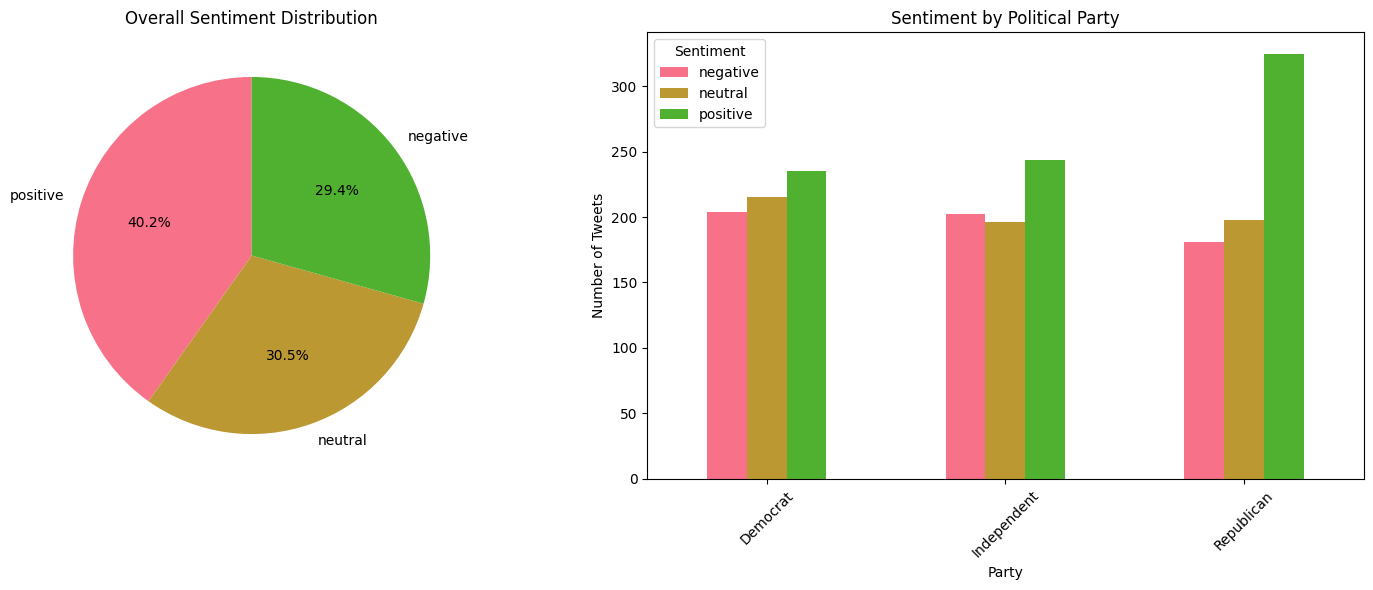

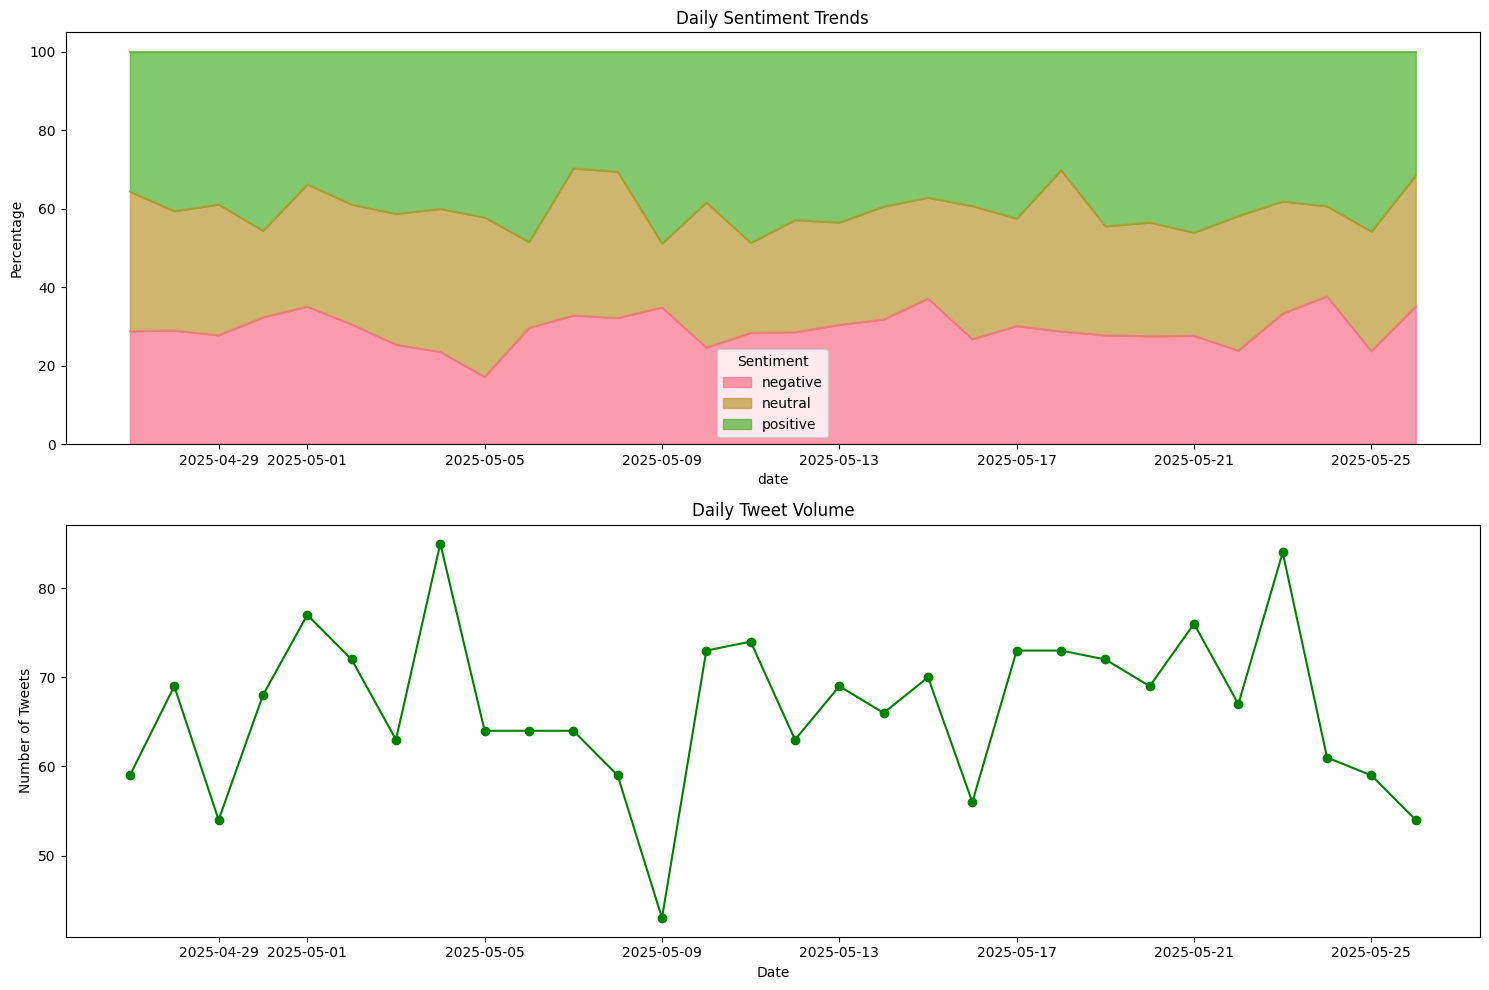

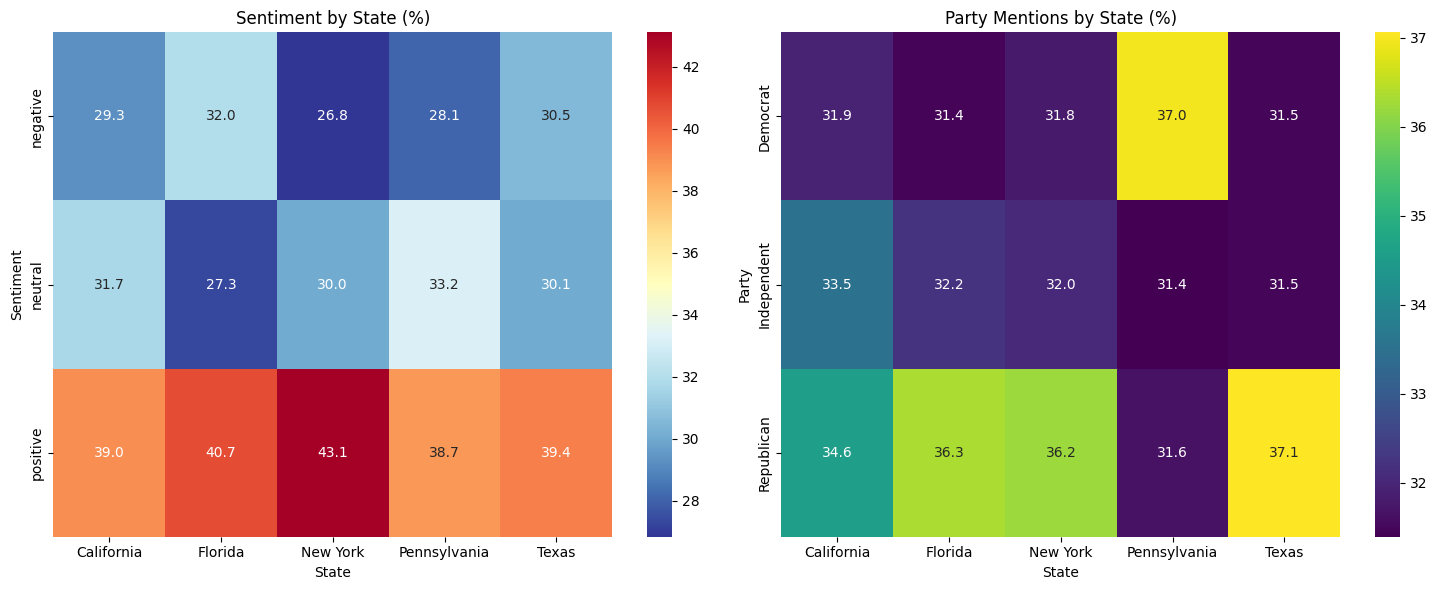

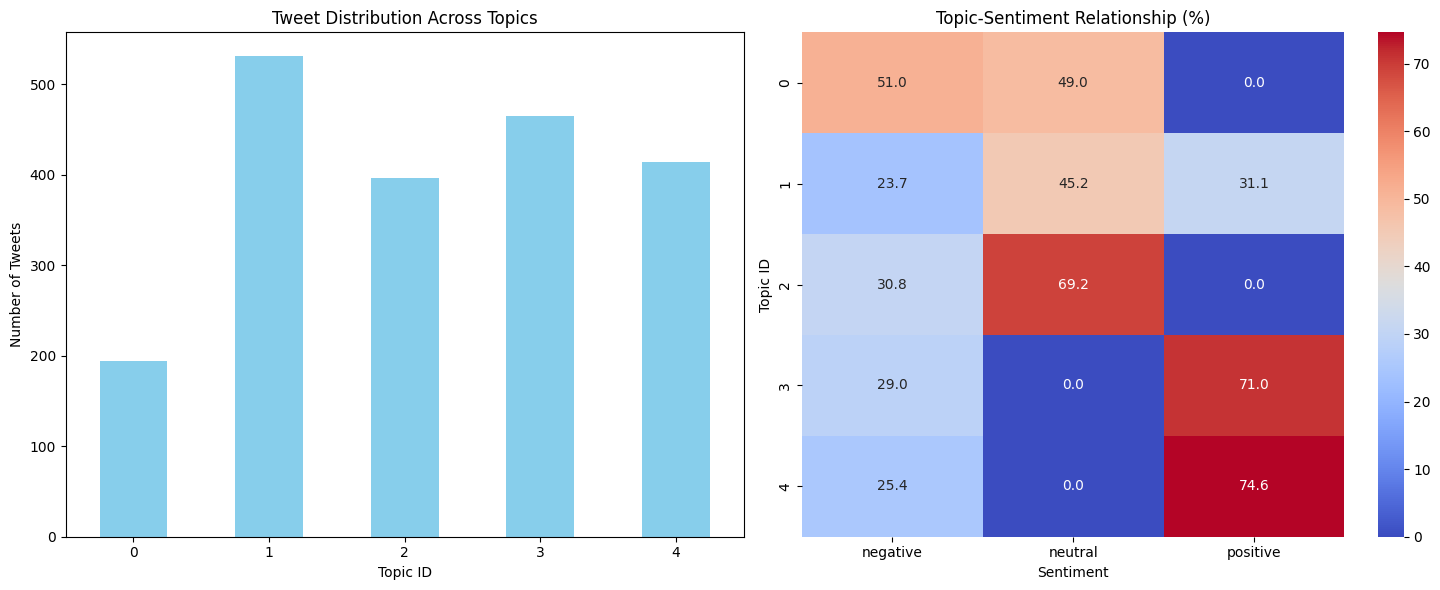

All visualizations created!


In [ ]:
plt.style.use('default')
sns.set_palette("husl")

def plot_sentiment_distribution():
    """Plot overall sentiment distribution"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Pie chart of sentiment distribution
    sentiment_counts = df['sentiment'].value_counts()
    ax1.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
    ax1.set_title('Overall Sentiment Distribution')

    # Bar chart by party
    party_sentiment = pd.crosstab(df['party_mentioned'], df['sentiment'])
    party_sentiment.plot(kind='bar', ax=ax2)
    ax2.set_title('Sentiment by Political Party')
    ax2.set_xlabel('Party')
    ax2.set_ylabel('Number of Tweets')
    ax2.legend(title='Sentiment')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

def plot_time_trends():
    """Plot sentiment trends over time"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Overall sentiment trends
    daily_sentiment_trends.plot(kind='area', stacked=True, ax=ax1, alpha=0.7)
    ax1.set_title('Daily Sentiment Trends')
    ax1.set_ylabel('Percentage')
    ax1.legend(title='Sentiment')

    # Tweet volume over time
    daily_volume = df.groupby('date').size()
    daily_volume.plot(ax=ax2, color='green', marker='o')
    ax2.set_title('Daily Tweet Volume')
    ax2.set_ylabel('Number of Tweets')
    ax2.set_xlabel('Date')

    plt.tight_layout()
    plt.show()

def plot_regional_analysis():
    """Plot regional sentiment analysis"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Regional sentiment heatmap
    sns.heatmap(regional_sentiment.T, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=ax1)
    ax1.set_title('Sentiment by State (%)')
    ax1.set_xlabel('State')
    ax1.set_ylabel('Sentiment')

    # Regional party preferences
    sns.heatmap(regional_party.T, annot=True, fmt='.1f', cmap='viridis', ax=ax2)
    ax2.set_title('Party Mentions by State (%)')
    ax2.set_xlabel('State')
    ax2.set_ylabel('Party')

    plt.tight_layout()
    plt.show()

def plot_topic_analysis():
    """Plot topic modeling results"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Topic distribution
    topic_counts = df['dominant_topic'].value_counts().sort_index()
    topic_counts = topic_counts[topic_counts.index >= 0]  # Remove -1 (no topic)
    topic_counts.plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('Tweet Distribution Across Topics')
    ax1.set_xlabel('Topic ID')
    ax1.set_ylabel('Number of Tweets')
    ax1.tick_params(axis='x', rotation=0)

    # Topic-Sentiment relationship
    topic_sentiment = pd.crosstab(df['dominant_topic'], df['sentiment'])
    topic_sentiment = topic_sentiment[topic_sentiment.index >= 0]  # Remove -1
    topic_sentiment_pct = topic_sentiment.div(topic_sentiment.sum(axis=1), axis=0) * 100
    sns.heatmap(topic_sentiment_pct, annot=True, fmt='.1f', cmap='coolwarm', ax=ax2)
    ax2.set_title('Topic-Sentiment Relationship (%)')
    ax2.set_xlabel('Sentiment')
    ax2.set_ylabel('Topic ID')

    plt.tight_layout()
    plt.show()

# Create all visualizations
print("Creating visualizations...")

plot_sentiment_distribution()
plot_time_trends()
plot_regional_analysis()
plot_topic_analysis()

print("All visualizations created!")

In [ ]:
def generate_summary_report():
    """Generate a comprehensive summary report"""
    print("=" * 60)
    print("ELECTION SENTIMENT ANALYSIS - SUMMARY REPORT")
    print("=" * 60)

    # Basic statistics
    total_tweets = len(df)
    print(f"\n📊 DATASET OVERVIEW")
    print(f"Total tweets analyzed: {total_tweets:,}")
    print(f"Date range: {df['created_at'].min().date()} to {df['created_at'].max().date()}")
    print(f"States covered: {df['state'].nunique()}")
    print(f"Political parties: {', '.join(df['party_mentioned'].unique())}")

    # Sentiment analysis results
    print(f"\n💭 SENTIMENT ANALYSIS RESULTS")
    sentiment_dist = df['sentiment'].value_counts(normalize=True) * 100
    for sentiment, percentage in sentiment_dist.items():
        print(f"{sentiment}: {percentage:.1f}%")

    # Party-wise sentiment
    print(f"\n🏛️ PARTY-WISE SENTIMENT")
    for party in df['party_mentioned'].unique():
        party_data = df[df['party_mentioned'] == party]
        party_sentiment = party_data['sentiment'].value_counts(normalize=True) * 100
        pos_pct = party_sentiment.get('POSITIVE', 0)
        neg_pct = party_sentiment.get('NEGATIVE', 0)
        print(f"{party}: {pos_pct:.1f}% positive, {neg_pct:.1f}% negative")

    # Regional insights
    print(f"\n🗺️ REGIONAL INSIGHTS")
    for state in df['state'].unique():
        state_data = df[df['state'] == state]
        state_sentiment = state_data['sentiment'].value_counts(normalize=True) * 100
        pos_pct = state_sentiment.get('POSITIVE', 0)
        tweet_count = len(state_data)
        print(f"{state}: {tweet_count} tweets, {pos_pct:.1f}% positive")

    # Topic insights
    print(f"\n📝 TOPIC INSIGHTS")
    print("Discovered topics:")
    for idx, topic in lda_model.print_topics(num_words=5):
        # Extract just the words for cleaner display
        words = [word.split('*')[1].replace('"', '').strip() for word in topic.split(' + ')]
        print(f"Topic {idx}: {', '.join(words[:5])}")

    # Engagement insights
    print(f"\n📈 ENGAGEMENT INSIGHTS")
    avg_retweets = df['retweets'].mean()
    avg_likes = df['likes'].mean()
    print(f"Average retweets per tweet: {avg_retweets:.1f}")
    print(f"Average likes per tweet: {avg_likes:.1f}")

    # Most engaging content by sentiment
    for sentiment in ['POSITIVE', 'NEGATIVE', 'NEUTRAL']:
        sentiment_data = df[df['sentiment'] == sentiment]
        if not sentiment_data.empty:
            avg_engagement = sentiment_data[['retweets', 'likes']].mean().sum()
            print(f"Average engagement for {sentiment} tweets: {avg_engagement:.1f}")

    print(f"\n✅ ANALYSIS COMPLETED")
    print("=" * 60)

# Generate the final report
generate_summary_report()

ELECTION SENTIMENT ANALYSIS - SUMMARY REPORT

📊 DATASET OVERVIEW
Total tweets analyzed: 2,000
Date range: 2025-04-27 to 2025-05-26
States covered: 5
Political parties: Independent, Democrat, Republican

💭 SENTIMENT ANALYSIS RESULTS
positive: 40.2%
neutral: 30.4%
negative: 29.3%

🏛️ PARTY-WISE SENTIMENT
Independent: 0.0% positive, 0.0% negative
Democrat: 0.0% positive, 0.0% negative
Republican: 0.0% positive, 0.0% negative

🗺️ REGIONAL INSIGHTS
Pennsylvania: 395 tweets, 0.0% positive
Florida: 388 tweets, 0.0% positive
New York: 406 tweets, 0.0% positive
California: 382 tweets, 0.0% positive
Texas: 429 tweets, 0.0% positive

📝 TOPIC INSIGHTS
Discovered topics:
Topic 0: economy, hurt, terrible, decision, policy
Topic 1: democrat, republican, independent, new, families
Topic 2: approaching, quickly, day, democrat, independent
Topic 3: republican, performance, debate, excellent, honest
Topic 4: republican, people, finally, working, listens

📈 ENGAGEMENT INSIGHTS
Average retweets per tweet: 

In [ ]:
def export_results():
    """Export analysis results to CSV files"""
    # Export main dataset with results
    df.to_csv('election_sentiment_analysis.csv', index=False)

    # Export summary statistics
    summary_stats = {
        'sentiment_distribution': df['sentiment'].value_counts(),
        'party_sentiment': pd.crosstab(df['party_mentioned'], df['sentiment']),
        'regional_sentiment': regional_sentiment,
        'daily_trends': daily_sentiment_trends
    }

    # Save each summary to separate CSV
    for name, data in summary_stats.items():
        data.to_csv(f'{name}.csv')

    print("Results exported to CSV files!")

def suggest_improvements():
    """Suggest ways to improve the analysis"""
    print("\n🚀 SUGGESTED IMPROVEMENTS FOR REAL-WORLD IMPLEMENTATION:")
    print("\n1. Data Collection:")
    print("   - Use Twitter API v2 for real-time data")
    print("   - Implement proper rate limiting")
    print("   - Collect more diverse data sources (Facebook, Reddit, news)")

    print("\n2. Text Processing:")
    print("   - Handle emojis and special characters better")
    print("   - Implement spell checking")
    print("   - Use more sophisticated preprocessing")

    print("\n3. Model Improvements:")
    print("   - Fine-tune BERT on political text")
    print("   - Experiment with different sentiment models")
    print("   - Use more advanced topic modeling (BERTopic)")

    print("\n4. Analysis Enhancements:")
    print("   - Add influence network analysis")
    print("   - Implement trend forecasting")
    print("   - Include demographic analysis")

    print("\n5. Visualization:")
    print("   - Create interactive dashboards with Plotly Dash")
    print("   - Add geographic mapping")
    print("   - Build real-time monitoring system")

# Export results and show improvements
export_results()
suggest_improvements()

print("\n🎉 PROJECT COMPLETED SUCCESSFULLY!")
print("You now have a complete sentiment analysis pipeline for election campaigns!")

Results exported to CSV files!

🚀 SUGGESTED IMPROVEMENTS FOR REAL-WORLD IMPLEMENTATION:

1. Data Collection:
   - Use Twitter API v2 for real-time data
   - Implement proper rate limiting
   - Collect more diverse data sources (Facebook, Reddit, news)

2. Text Processing:
   - Handle emojis and special characters better
   - Implement spell checking
   - Use more sophisticated preprocessing

3. Model Improvements:
   - Fine-tune BERT on political text
   - Experiment with different sentiment models
   - Use more advanced topic modeling (BERTopic)

4. Analysis Enhancements:
   - Add influence network analysis
   - Implement trend forecasting
   - Include demographic analysis

5. Visualization:
   - Create interactive dashboards with Plotly Dash
   - Add geographic mapping
   - Build real-time monitoring system

🎉 PROJECT COMPLETED SUCCESSFULLY!
You now have a complete sentiment analysis pipeline for election campaigns!
